# Soil moisture forecasting using Gaussian Processes

### Import libraries

In [124]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split

In [ ]:
""" 
Variables:
ET_PM = potential Evapotranpiration
tho = initial soil moisture
x_ = features
y_ = Target values
TH = soil moisture estimated
IT = Irrigation Time
"""

### Import data

In [101]:
# Importing values

df_ET = pd.read_csv(r"C:\Users\alexd\Desktop\Pruebas\SM\ET.csv") #Evapotranspiration
df_SM = pd.read_csv(r"C:\Users\alexd\Desktop\Pruebas\SM\SM.csv") #Soil moisture values


df_IT = df_SM[['Date', 'IT']].copy()

# EVAPO

df_ET["Date"] =  pd.to_datetime(df_ET["Date"], format="%d/%m/%Y")
df_ET.set_index(df_ET['Date'], inplace=True)
df_ET = df_ET.resample('D').sum()
df_ET

# SM
df_SM = df_SM.drop(columns=['IT'])
df_SM["Date"] =  pd.to_datetime(df_SM["Date"], format="%d/%m/%Y")
df_SM.set_index(df_SM['Date'], inplace=True)

df_SM = df_SM.resample('D').mean()
df_SM

# IRRIGATION TIME

df_IT["Date"] =  pd.to_datetime(df_IT["Date"], format="%d/%m/%Y")
df_IT.set_index(df_IT['Date'], inplace=True)

df_IT = df_IT.resample('D').sum()
df_IT

# Merging dataframes

inner_merged = pd.merge(df_ET, df_SM,left_index=True, right_index=True)
inner_merged = pd.merge(inner_merged, df_IT,left_index=True, right_index=True)
inner_merged.index.names = ['ds']

C:\Users\alexd\AppData\Local\Temp\ipykernel_16212\1116174896.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ET = df_ET.resample('D').sum()
C:\Users\alexd\AppData\Local\Temp\ipykernel_16212\1116174896.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_SM = df_SM.resample('D').mean()
C:\Users\alexd\AppData\Local\Temp\ipykernel_16212\1116174896.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_IT = df_I

In [102]:
inner_merged.dropna(inplace=True)
#inner_merged.fillna(method='ffill')

In [103]:
inner_merged

,ET-PM,TH21,TH22,TH23,TH24,IT
ds,,,,,,
2000-02-21,1.9903,0.4195,0.4225,0.3180,0.3670,0.00
2000-02-22,2.7408,0.4260,0.4275,0.3210,0.3660,0.00
2000-02-23,0.4636,0.4285,0.4290,0.3225,0.3715,0.00
2000-02-24,2.7524,0.4285,0.4240,0.3215,0.3730,0.00
2000-02-25,1.7009,0.4235,0.4190,0.3170,0.3695,0.00
...,...,...,...,...,...,...
2001-02-13,2.5515,0.4495,0.4225,0.2995,0.3385,145.95
2001-02-14,2.8816,0.4485,0.4250,0.2995,0.3360,150.33
2001-02-15,2.5347,0.4540,0.4295,0.3025,0.3410,146.71


In [127]:
#Import measured data

init = 0

inner_merged["day"] = np.arange(0, 247, 1, dtype=int)
cP= inner_merged["IT"].values
ETo = inner_merged["ET-PM"].values



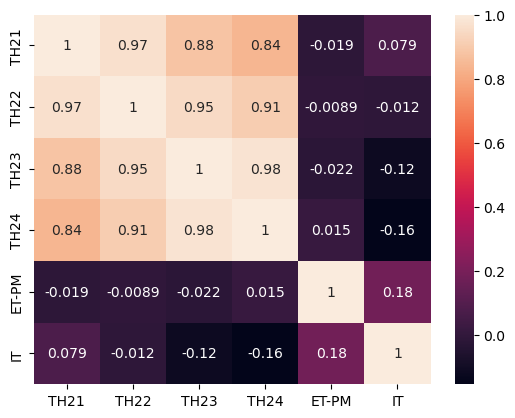

In [125]:
#Correlation matrix
data = inner_merged[["TH21","TH22","TH23","TH24","ET-PM","IT"]]

corr_matrix = data.corr()

sn.heatmap(corr_matrix, annot=True)
plt.show()



In [131]:
#Initial soil moistures values
tho = inner_merged[["TH21","TH22","TH23","TH24"]][init:init+1].values

# Features matrix

x_ = inner_merged[["TH21","TH22","TH23","TH24"]][init:-1]
x_["IT"]= inner_merged[["IT"]][init+1:].values
x_["ET-PM"]= inner_merged[["ET-PM"]][init+1:].values


x_["day"] = inner_merged[["day"]][init+1:].values

x_=np.atleast_2d(x_.values)


#Target values
y_ = np.atleast_2d(inner_merged[["TH21","TH22","TH23","TH24"]].values[init+1:])


### Training

In [163]:
# Instantiate a Gaussian Process model
kernel = 1.0 * RBF([.8,.6,.3,.3,.1,.1],(.15,.3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e-3))
gp = GaussianProcessRegressor(alpha=1e-4,
                              kernel=kernel,
                              n_restarts_optimizer=10, 
                              normalize_y=True,
                              optimizer='fmin_l_bfgs_b')

# Data split
x_train, x_test, y_train, y_test = train_test_split(x_, y_, 
                                                    test_size=0.2,
                                                    shuffle = False)

# Fit to data using Maximum Likelihood Estimation of the parameters
x_train2 = x_train[:,:-1]
gp.fit(x_train2, y_train)



C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified lower bound 0.15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified lower bound 0.15. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tsa\lib\site-packages\

GaussianProcessRegressor(alpha=0.0001,
                         kernel=1**2 * RBF(length_scale=[0.8, 0.6, 0.3, 0.3, 0.1, 0.1]) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=10, normalize_y=True)

### Forecasting

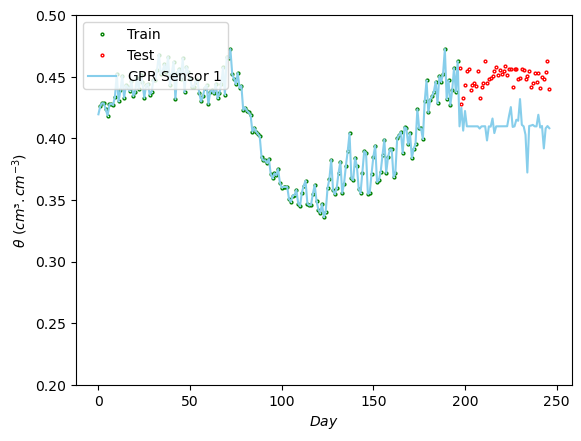

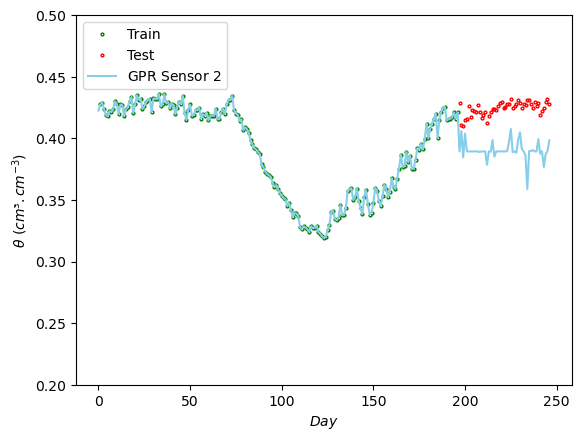

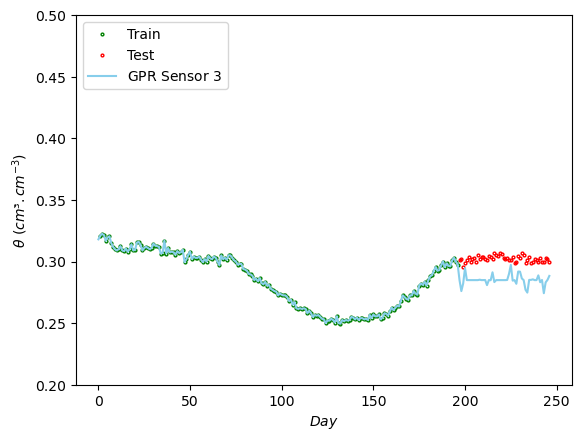

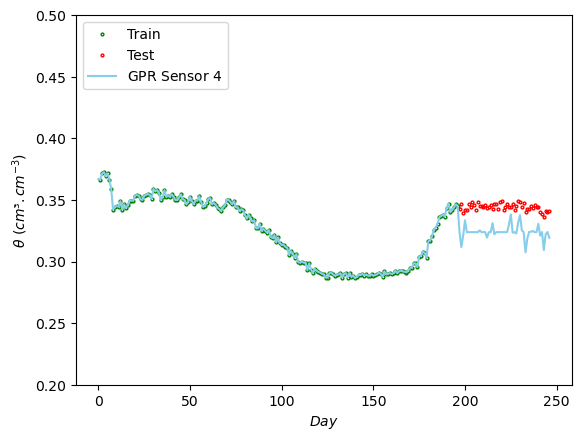

In [164]:
# Make the prediction
# In this loop the values are estimated with the initial moisture with interactive method
# were Th[i+1] is calculeted with TH[i]

TH = tho.tolist()
for i in range(len(y_)):
    TH.append(gp.predict(np.atleast_2d(np.concatenate((TH[i],cP[i+init+1],ETo[i+init+1]), axis=None)))[0])

TH = np.array(TH)

# Plot the mensured data and simulated data
for i in range(len(TH[0])):
    plt.plot(x_train[:,len(x_test[1,:])-1], y_train[:,i],'.',c = 'green',markersize=4, markerfacecolor="None", label='Train')
    plt.plot(x_test[:,len(x_test[1,:])-1], y_test[:,i], '.',c='red',markersize=4, markerfacecolor="None", label='Test')
    
    plt.plot(TH[:,i], 'skyblue', label='GPR Sensor '+r'$ %d$'%(i+1))

    plt.xlabel('$Day$')
    plt.ylabel(r'$ \theta\ (cm³.cm^{-3})$')
    plt.ylim(.2, .5)
    plt.legend(loc='upper left')
    plt.show()
    
